## <center> ONFM : Failure Detection

#### Importing required packages

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline  
#will make plot outputs appear and be stored within the notebook.

plt.style.reload_library()
plt.style.use([ 'science', 'ieee','notebook'])

import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

Following block will control the randomness of simulation i.e., simulation will give same results for each run as long as seed is fixed for different packages like numpy and tensorflow etc.

In [2]:
import os
SEED = 42

os.environ['PYTHONHASHSEED'] =str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Following block will import data from csv file stored on local system, drop irrelevant columns/features, and output resultant dataframe.

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def get_final_dataset():
    
    df = pd.read_excel('New_data_combined.xlsx') # Dataset is now stored in a Pandas Dataframe#
    df = df.sample(df.shape[0])   #shuffling
    df.reset_index(drop = True , inplace = True)
#     df = df.drop_duplicates()   #dropping duplicates
    
    cols_to_drop = ['A1_Pin' , 'A1_Pout' , 'A3_Pin' ,'A3_Pout' , 'A4_Pin', 'A4_Pout','CD', 'Q-Factor' , 'A2_Pout' ]
    df.drop(cols_to_drop ,axis = 'columns', inplace = True)
    
    # in python starts from 0
    
#     cols_to_scale = ['OSNR', 'BER','A2_Pin']
#     df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    return df


Following function plots data in 3D.

In [4]:
import plotly.express as px

def plot_dataset(df):
    fig = px.scatter_3d(df, x='BER', y='OSNR', z='A2_Pin', color= 'Failure_Type')
    fig.show()


Importing dataset as a pandas dataframe. It can be seen that it is not scaled up till now. we'll scale it after combining with synthetic data to ensure uniform scaling.

In [5]:
dataset = get_final_dataset()
dataset.head()

,A2_Pin,OSNR,BER,Alarm,Failure_Type
0,-23.4,23.8,2.480000e-07,0,0
1,-23.4,23.6,2.490000e-07,0,0
2,-23.7,22.9,7.500000e-07,0,0
3,-29.7,19.6,2.520000e-05,1,2
4,-30.8,17.0,8.930660e-04,1,3


In [6]:
print ('\n Number of Samples for each failure Type :')
print ('\n\n Before dropping duplicates : \n')
print (dataset.Failure_Type.value_counts())
print ('\n\n After dropping duplicates : \n')
dataset.drop_duplicates(inplace = True)
print (dataset.Failure_Type.value_counts())


 Number of Samples for each failure Type :


 Before dropping duplicates : 

0    29998
4     1000
1     1000
2      999
3      999
5      999
Name: Failure_Type, dtype: int64


 After dropping duplicates : 

0    2514
3     991
5     325
4     257
1     224
2     152
Name: Failure_Type, dtype: int64


In [7]:
print (dataset.Alarm.value_counts())

0    2514
1    1949
Name: Alarm, dtype: int64


#### Data processing
Following block will return train, validation and test datasets for our analysis. A decent size for valdiation and test data sets is required to get stable performance. Small validation dataset as compared to training dataset may result in fluctuations of validation accuracy and loss during training.

Note:

30% split ratio is used for test and validation sets. stratify = y, ensure that test data set follows the same distribution as it was in original dataset.

In [8]:
from sklearn.model_selection import train_test_split

def get_train_test_validation_data(df):
    
    X = df.drop(['Failure_Type', 'Alarm'], axis = 'columns')
    y = df['Alarm']
    
    X_train_val , X_test, y_train_val, y_test = train_test_split (X, y , test_size = 0.30, random_state = SEED , stratify = y)
    X_train , X_val, y_train, y_val = train_test_split (X_train_val, y_train_val , test_size = 0.30, random_state = SEED , stratify = y_train_val)
    
    return X_train, y_train, X_test, y_test, X_val, y_val

Getting training, test and validation data from our original failure data.

In [9]:
X_train, y_train, X_test, y_test, X_val, y_val = get_train_test_validation_data(dataset)

In [10]:
print ('\n Shapes for different datasets: \n')
print ('\n X_train :', X_train.shape )
print ('\n X_test :', X_test.shape )
print ('\n X_validation :', X_val.shape )


 Shapes for different datasets: 


 X_train : (2186, 3)

 X_test : (1339, 3)

 X_validation : (938, 3)


Note that training dataset used for training ML classifier is not balanced. Normal operation has slightly more instances as compared to failure instances. It won't impact much as difference is not much but still a balanced dataset improves classifier's problem and we'll see that. It speed ups training process. As classifier does not need more epochs to overcome bias of the dataset if our training dataset is balanced.

- Classifier will see equal examples of both class samples during training which will make it easier to learn underlying patterns for both classes. Hence, it takes less epochs to achieve 100% accuracy.

In [11]:
y_train.value_counts()

0    1232
1     954
Name: Alarm, dtype: int64

In [12]:
X_train.head()

,A2_Pin,OSNR,BER
28388,-23.3,23.8,2.630000e-07
21276,-29.7,19.6,1.900000e-05
8808,-23.7,22.7,7.450000e-07
3402,-23.7,23.0,7.240000e-07
1979,-23.4,23.5,2.750000e-07


In [13]:
X_test.head()

,A2_Pin,OSNR,BER
1737,-23.4,23.6,2.850000e-07
127,-23.4,23.7,2.560000e-07
25939,-30.8,17.0,9.111060e-04
11118,-23.7,22.8,7.830000e-07
770,-23.7,22.8,7.240000e-07


In [14]:
X_val.head()

,A2_Pin,OSNR,BER
25903,-23.7,23.1,4.990000e-07
28637,-30.8,17.0,9.119260e-04
71,-27.9,19.6,5.020000e-05
321,-23.4,23.9,1.960000e-07
6202,-24.8,19.7,4.290000e-05


For modified dataset i.e., balanced because of real + synthetic samples.

In [15]:
## importing augmented/synthetic failure data
# saved in the classification notebook after selecting best failure samples

df_synthetic = pd.read_csv('Synthetic_Selected_failure_data.csv') # Dataset is now stored in a Pandas Dataframe
df_synthetic.shape

(1471, 5)

Combining training data alongwith its labels for concatenation with synthetic failure data.

In [16]:
df_train_org = X_train.copy()
df_train_org['Alarm'] = y_train.values
df_train_org.shape

(2186, 4)

In [17]:
df_train_org.head()

,A2_Pin,OSNR,BER,Alarm
28388,-23.3,23.8,2.630000e-07,0
21276,-29.7,19.6,1.900000e-05,1
8808,-23.7,22.7,7.450000e-07,0
3402,-23.7,23.0,7.240000e-07,0
1979,-23.4,23.5,2.750000e-07,0


Appending only that number of synthetic failure samples which will make both classes balanced.

In [18]:
synthetic_failure_samples = df_synthetic.sample(y_train.value_counts()[0] - y_train.value_counts()[1])
synthetic_failure_samples.shape

(278, 5)

In [19]:
synthetic_failure_samples.head()

,A2_Pin,OSNR,BER,Failure_Type,Alarm
119,-29.656189,19.571243,0.000023,1,1
1421,-25.795311,20.308714,0.000013,4,1
1466,-25.869047,20.326433,0.000013,4,1
673,-27.963072,19.399576,0.000045,3,1
646,-27.971159,19.411041,0.000044,3,1


In [20]:
synthetic_failure_samples = synthetic_failure_samples.drop('Failure_Type', axis = 'columns')
synthetic_failure_samples.head()

,A2_Pin,OSNR,BER,Alarm
119,-29.656189,19.571243,0.000023,1
1421,-25.795311,20.308714,0.000013,1
1466,-25.869047,20.326433,0.000013,1
673,-27.963072,19.399576,0.000045,1
646,-27.971159,19.411041,0.000044,1


In [21]:
training_data_modifed = pd.concat([synthetic_failure_samples,df_train_org] , ignore_index = True)
training_data_modifed.head()

,A2_Pin,OSNR,BER,Alarm
0,-29.656189,19.571243,0.000023,1
1,-25.795311,20.308714,0.000013,1
2,-25.869047,20.326433,0.000013,1
3,-27.963072,19.399576,0.000045,1
4,-27.971159,19.411041,0.000044,1


In [22]:
training_data_modifed = training_data_modifed.sample(training_data_modifed.shape[0])
training_data_modifed.head()

,A2_Pin,OSNR,BER,Alarm
1588,-23.4,23.6,2.190000e-07,0
696,-25.7,20.5,1.040000e-05,1
1874,-23.3,23.8,2.680000e-07,0
406,-23.7,23.2,7.190000e-07,0
1944,-27.9,19.5,5.430000e-05,1


In [23]:
training_data_modifed.describe()

,A2_Pin,OSNR,BER,Alarm
count,2464.000000,2464.000000,2.464000e+03,2464.000000
mean,-25.982769,21.013752,1.827039e-04,0.500000
std,2.946881,2.498576,3.496450e-04,0.500101
min,-30.800000,16.800000,1.660000e-07,0.000000
25%,-29.572821,19.500000,5.587500e-07,0.000000
50%,-24.250000,21.750000,3.853500e-06,0.500000
75%,-23.700000,23.125000,4.660870e-05,1.000000
max,-23.300000,24.200000,9.248470e-04,1.000000


In [24]:
X_train_modified = training_data_modifed.drop('Alarm', axis = 'columns')
y_train_modified = training_data_modifed['Alarm']

In [25]:
X_train_modified.shape , y_train_modified.shape

((2464, 3), (2464,))

In [26]:
y_train_modified.value_counts()

0    1232
1    1232
Name: Alarm, dtype: int64

#### Modified (Balanced) training data is ready!!!

Sorting columns of x_test, x_val, x_train and x_train_modified to ensure uniformity.

In [27]:
X_val = X_val.reindex(sorted(X_val.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_train_modified = X_train_modified.reindex(sorted(X_train_modified.columns), axis=1)

In [28]:
X_train_modified.head(1)

,A2_Pin,BER,OSNR
1588,-23.4,2.190000e-07,23.6


In [29]:
X_train.head(1)

,A2_Pin,BER,OSNR
28388,-23.3,2.630000e-07,23.8


In [30]:
X_test.head(1)

,A2_Pin,BER,OSNR
1737,-23.4,2.850000e-07,23.6


In [31]:
X_val.head(1)

,A2_Pin,BER,OSNR
25903,-23.7,4.990000e-07,23.1


Normalizing  x_test, x_val, x_train and x_train_modified!

In [32]:
cols_to_scale = ['OSNR', 'BER','A2_Pin']

X_val[cols_to_scale] = scaler.fit_transform(X_val[cols_to_scale])
X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])
X_train_modified[cols_to_scale] = scaler.fit_transform(X_train_modified[cols_to_scale])
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

#### Failure Detector:

A machine learning classifier.

- A simple neural network with 1 hidden layer containing 2 neurons.
- Sigmoid activation function at output layer performs better than softmax (usually) for binary classification.

In [33]:
 def build_NN():

  nn_input = Input(shape = (3,), name='Input Layer')
  x = Dense(2 , activation = 'relu')(nn_input)  
  x = Dense(1, activation= 'sigmoid')(x)        #check it later on
 
  return keras.Model(nn_input, x, name='Failure_Detector')

Following block tracks time for epochs!

In [34]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [35]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
opt = keras.optimizers.Adam(learning_rate=0.0008 , beta_1 = 0.4)
time_callback = TimeHistory()

def get_trained_dnn(X_train1, y_train1,X_val, y_val): 
    model = build_NN()
    model.summary()
    model.compile (optimizer = opt ,loss ='binary_crossentropy',metrics = ['accuracy'])
    history = model.fit(X_train1, y_train1 , epochs = 50 , batch_size = 8,  validation_data=(X_val, y_val), callbacks=[time_callback])
    times = time_callback.times
    return model, history, times

For printing results:

In [36]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sn

def print_plot_results(model, history, X_test, y_test):
    print('Performance on Test Data : \n')
    model.evaluate(X_test, y_test)
    
    yp  = model.predict(X_test)   ##gives values between 0 and 1
    
    y_pred = []
    for element in yp:
        if element > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    cm = tf.math.confusion_matrix(labels=y_test,predictions= y_pred)
    
    print('\n\nClassification Report : \n')
    print(classification_report(y_test, y_pred ))
    
    print('\n\nConfusion Matrix : \n')
    
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

Following function computes and returns time required for achieving 100% (maximum) accuracy with modified and imbalanced datasets.


In [37]:
def get_time_difference(time1, time2, hist1, hist2):
    
    val_acc_modified_data = hist2.history['val_accuracy']
    time_for_modifed_data = time2
    val_acc_real_data = hist1.history['val_accuracy']
    time_for_real_data = time1

    max_index_modified_data  = val_acc_modified_data.index(max(val_acc_modified_data)) + 1     #+1 because indices in a list start from 0 but epochs start from 1
    max_index_real_data  = val_acc_real_data.index(max(val_acc_real_data)) + 1
    
    time_taken_for_modified_data = sum(time_for_modifed_data[:max_index_modified_data])
    time_for_real_data = sum(time_for_real_data[:max_index_real_data])
    
    
    "{0:.2f}"
    print("\nTime Taken by Real Training Data for achieving 100% or highest accuracy : {0:.2f} seconds. ".format(time_for_real_data) )
    print("\nTime Taken by Modified Training Data for achieving 100% or highest accuracy : {0:.2f} seconds. ".format(time_taken_for_modified_data))
    time_difference = time_for_real_data - time_taken_for_modified_data
    percentage_difference = 100 * time_difference/ time_for_real_data 
    print("\nTime difference : {0:.2f} seconds. ".format(time_difference))
    print("\nPercentage Time difference : {0:.2f} %. ".format(percentage_difference))
    return time_difference, max_index_real_data, max_index_modified_data
    

In [38]:
# #hist1 : normal data
# #hist2: augmented data

# def plot_acc_loss_curves(hist1, hist2, time1, time2):
    
#     m_size = 8
#     #Loss curves
#     plt.figure(figsize = (10,7))
#     plt.plot(hist2.history['loss'] , marker='o',markevery=5 , markersize= m_size)  #after evey 5 because with 100 markers it looks messy
#     plt.plot(hist2.history['val_loss'], marker='v',markevery=5, markersize= m_size)
#     plt.plot(hist1.history['loss'], marker='s',markevery=5, markersize= m_size)
#     plt.plot(hist1.history['val_loss'], marker='*',markevery=5, markersize= m_size)
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('epoch')
#     plt.grid(linestyle = '--', linewidth = 0.5)
#     plt.legend(['Loss for modified dataset', 'Validation Loss for modified dataset','Loss for old dataset', 'Validation Loss for old dataset'])
#     plt.show()
    
#     time_difference, max_index_real_data, max_index_modified_data = get_time_difference(time1, time2, hist1, hist2)
            
#     #accuracy
#     plt.figure(figsize = (10,7))
#     plt.plot(hist2.history['accuracy'], marker='o',markevery=5, markersize= m_size)
#     plt.plot(hist2.history['val_accuracy'], marker='v',markevery=5, markersize= m_size)
#     plt.plot(hist1.history['accuracy'], marker='s',markevery=5, markersize= m_size)
#     plt.plot(hist1.history['val_accuracy'], marker='*',markevery=5, markersize= m_size)
    
#     plt.title('Model accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('epoch')
#     plt.grid(linestyle = '--', linewidth = 0.5)
#     plt.legend(['Accuracy for modified dataset', 'Validation accuracy for modified dataset','Accuracy for old dataset', 'Validation accuracy for old dataset'])
#     plt.show()
    

In [39]:
#hist1 : normal data
#hist2: augmented data

def  plot_acc_loss_curves(hist1, hist2, time1, time2):
    
    m_size = 8   #marker_size
    l_width = 3
    
    time1 = np.array(time1)
    cummulative_time1 = time1.cumsum()
    
    time2 = np.array(time2)
    cummulative_time2 = time2.cumsum()
    
    #Loss curves
    plt.figure(figsize = (10,7))
    plt.plot(hist2.history['loss']  , linewidth=l_width, marker='o',markevery=5 , markersize= m_size)  #after evey 5 because with 100 markers it looks messy
    plt.plot(hist2.history['val_loss'] , linewidth=l_width, marker='v',markevery=5, markersize= m_size)
    plt.plot(hist1.history['loss'] , linewidth=l_width, marker='s',markevery=5, markersize= m_size)
    plt.plot(hist1.history['val_loss'] , linewidth=l_width, marker='*',markevery=5, markersize= m_size)
#     plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(['Training Loss for modified dataset', 'Validation Loss for modified dataset','Training Loss for real dataset', 'Validation Loss for real dataset'])
    plt.show()
    
    time_difference, max_index_real_data, max_index_modified_data = get_time_difference(time1, time2, hist1, hist2)
            
    #accuracy
    plt.figure(figsize = (10,7))
    plt.plot(hist2.history['accuracy'] , linewidth=l_width , marker='o',markevery=5, markersize= m_size)
    plt.plot(hist2.history['val_accuracy'], linewidth=l_width, marker='v',markevery=5, markersize= m_size)
    plt.plot(hist1.history['accuracy'], linewidth=l_width, marker='s',markevery=5, markersize= m_size)
    plt.plot(hist1.history['val_accuracy'], linewidth=l_width, marker='*',markevery=5, markersize= m_size)
    
#     plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(['Training Accuracy for modified dataset', 'Validation accuracy for modified dataset','Training Accuracy for real dataset', 'Validation accuracy for real dataset'])
    plt.show()
    
    
    #Loss curves
    plt.figure(figsize = (10,7))
    plt.plot(cummulative_time2, hist2.history['loss']  , linewidth=l_width, marker='o',markevery= 10 , markersize= m_size)  #after evey 5 because with 100 markers it looks messy
    plt.plot(cummulative_time2, hist2.history['val_loss'] , linewidth=l_width, marker='v',markevery=10, markersize= m_size)
    plt.plot(cummulative_time1, hist1.history['loss'] , linewidth=l_width, marker='s',markevery=10, markersize= m_size)
    plt.plot(cummulative_time1, hist1.history['val_loss'] , linewidth=l_width, marker='*',markevery=10, markersize= m_size)
#     plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Time (seconds)')
    up_xlim = np.min([np.max(cummulative_time2), np.max(cummulative_time1)])
    plt.xlim([0,up_xlim])
    plt.grid(linestyle = '-', linewidth = 1.0)
    plt.legend(['Training Loss for modified dataset', 'Validation Loss for modified dataset','Training Loss for real dataset', 'Validation Loss for real dataset'])
    plt.show()
    
   #accuracy
    plt.figure(figsize = (10,7))
    plt.plot(cummulative_time2, hist2.history['accuracy'] , linewidth=l_width, marker='o',markevery=10, markersize= m_size)
    plt.plot(cummulative_time2, hist2.history['val_accuracy'] , linewidth=l_width, marker='v',markevery=10, markersize= m_size)
    plt.plot(cummulative_time1, hist1.history['accuracy'] , linewidth=l_width, marker='s',markevery=10, markersize= m_size)
    plt.plot(cummulative_time1, hist1.history['val_accuracy'] , linewidth=l_width, marker='*',markevery=10, markersize= m_size)
    
#     plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Time (seconds)')
    up_xlim = np.min([np.max(cummulative_time2), np.max(cummulative_time1)])
    plt.xlim([0,up_xlim])
    plt.grid(linestyle = '-', linewidth = 1.0)
    plt.legend(['Training Accuracy for modified dataset', 'Validation accuracy for modified dataset','Training Accuracy for real dataset', 'Validation accuracy for real dataset'])
    plt.show()
    

### Performance Comparison:

With imbalanced training data i.e., original data.

In [40]:
model1, history1, time1 = get_trained_dnn(X_train, y_train,X_val, y_val)

Model: "Failure_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 2)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
274/274 [==============================] - 3s 6ms/step - loss: 0.6705 - accuracy: 0.5704 - val_loss: 0.6404 - val_accuracy: 0.5629
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 0.6077 - accuracy: 0.5636 - val_loss: 0.5763 - val_accuracy: 0.5629
Epoch 3/50
274/274 [==============

Performance on Test Data : 

42/42 [==============================] - 0s 4ms/step - loss: 0.0123 - accuracy: 1.0000


Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       754
           1       1.00      1.00      1.00       585

    accuracy                           1.00      1339
   macro avg       1.00      1.00      1.00      1339
weighted avg       1.00      1.00      1.00      1339



Confusion Matrix : 



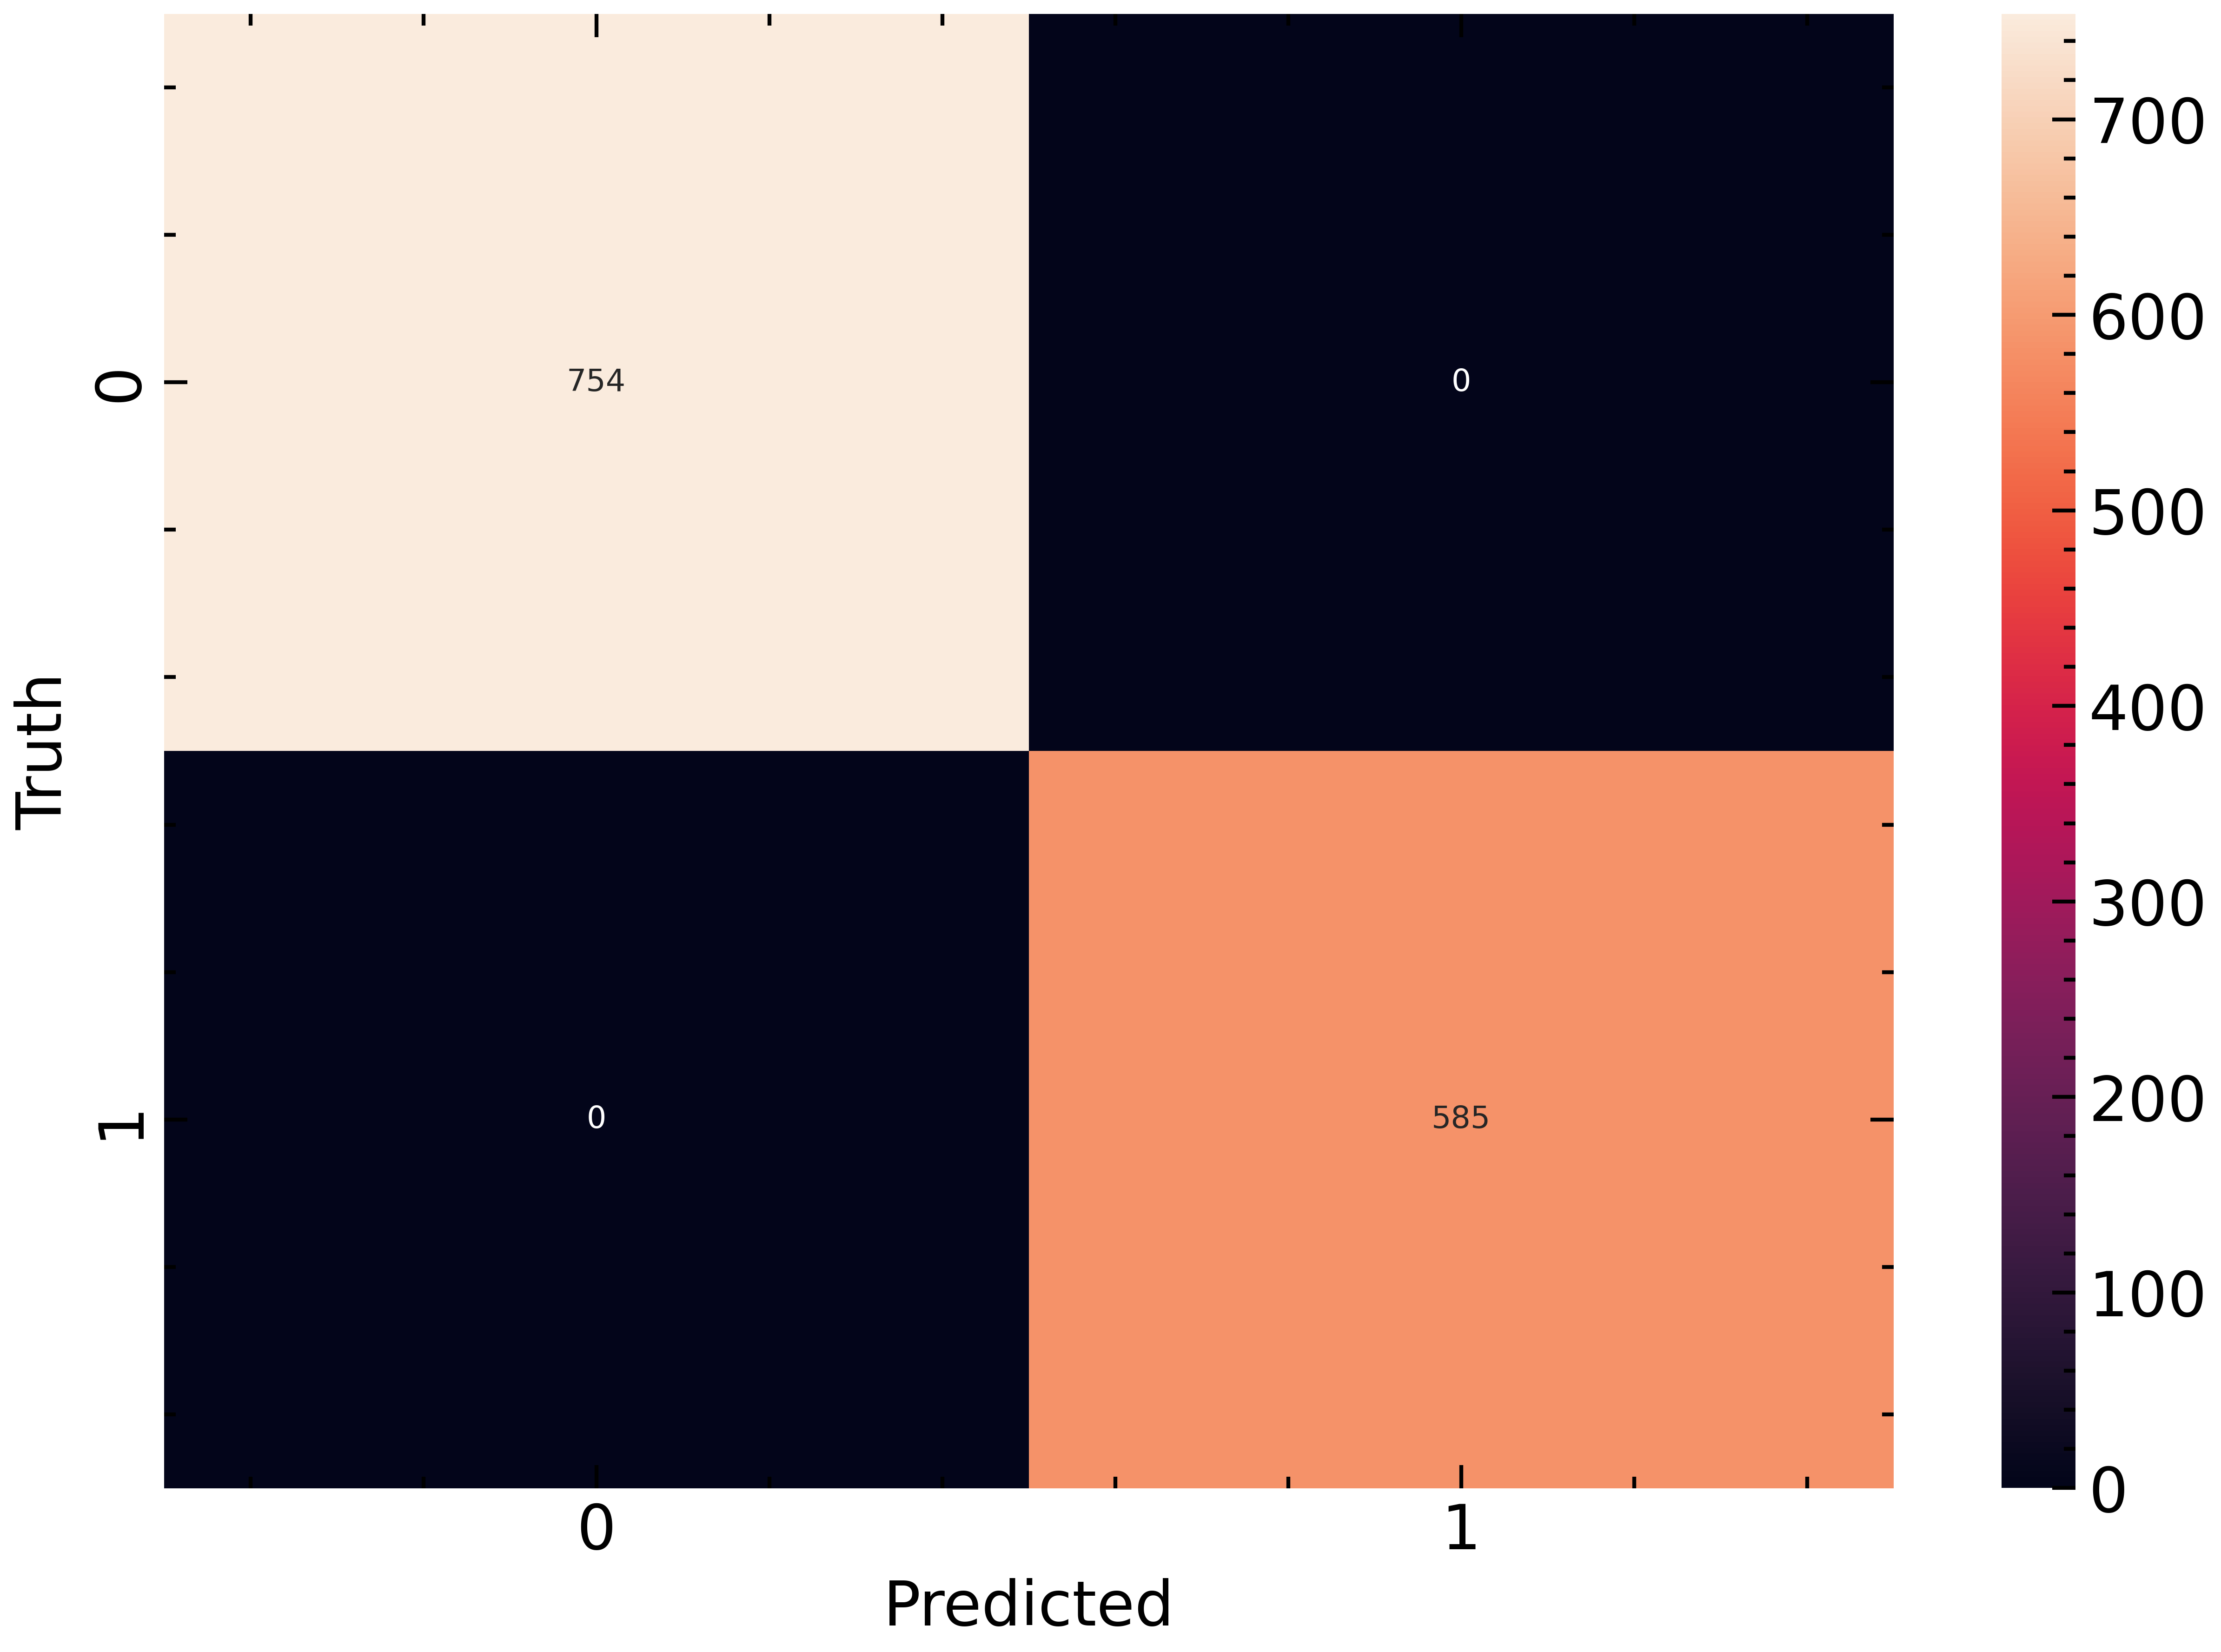

In [41]:
print_plot_results(model1, history1, X_test, y_test)

With modified dataset i.e., balanced !

- Synthetic + Real samples

In [42]:
model2, history2, time2 = get_trained_dnn(X_train_modified, y_train_modified,X_val, y_val)

Model: "Failure_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
308/308 [==============================] - 3s 8ms/step - loss: 0.6122 - accuracy: 0.6457 - val_loss: 0.5207 - val_accuracy: 0.7804
Epoch 2/50
308/308 [==============================] - 2s 6ms/step - loss: 0.5250 - accuracy: 0.7476 - val_loss: 0.4551 - val_accuracy: 0.8113
Epoch 3/50
308/308 [==============

Performance on Test Data : 

42/42 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 1.0000


Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       754
           1       1.00      1.00      1.00       585

    accuracy                           1.00      1339
   macro avg       1.00      1.00      1.00      1339
weighted avg       1.00      1.00      1.00      1339



Confusion Matrix : 



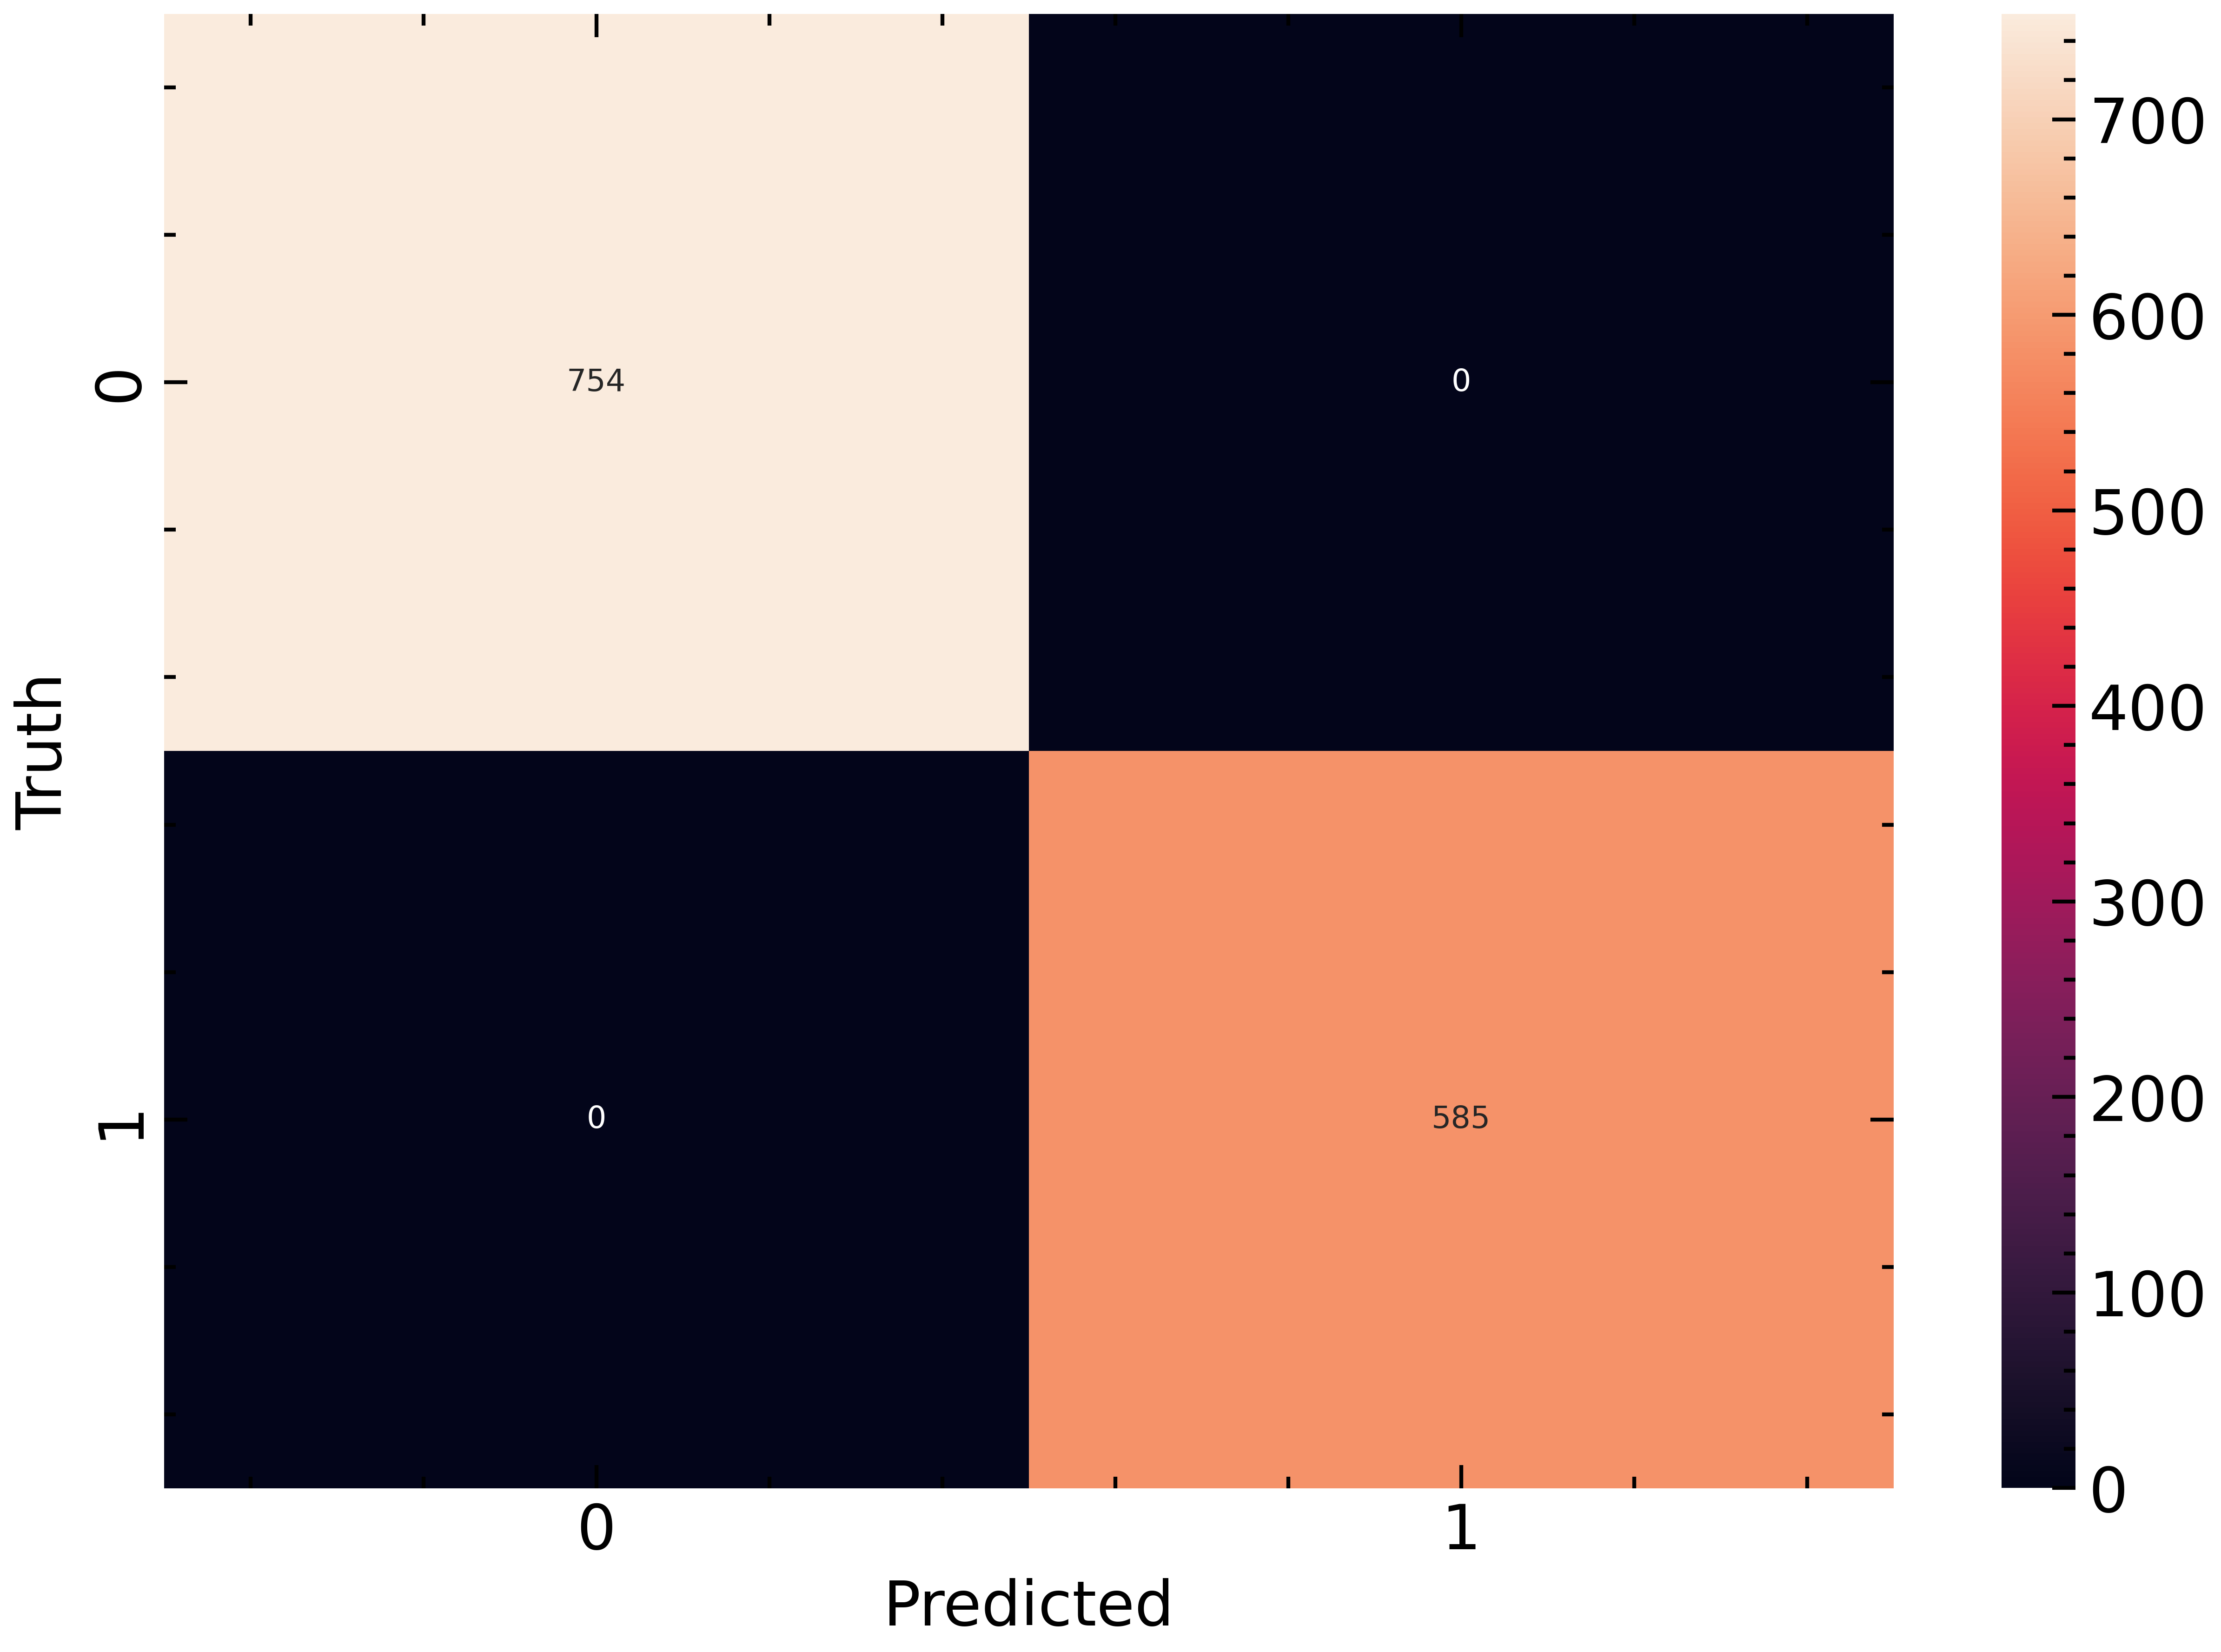

In [43]:
print_plot_results(model2, history2, X_test, y_test)

#### Compares performance of both graphically.

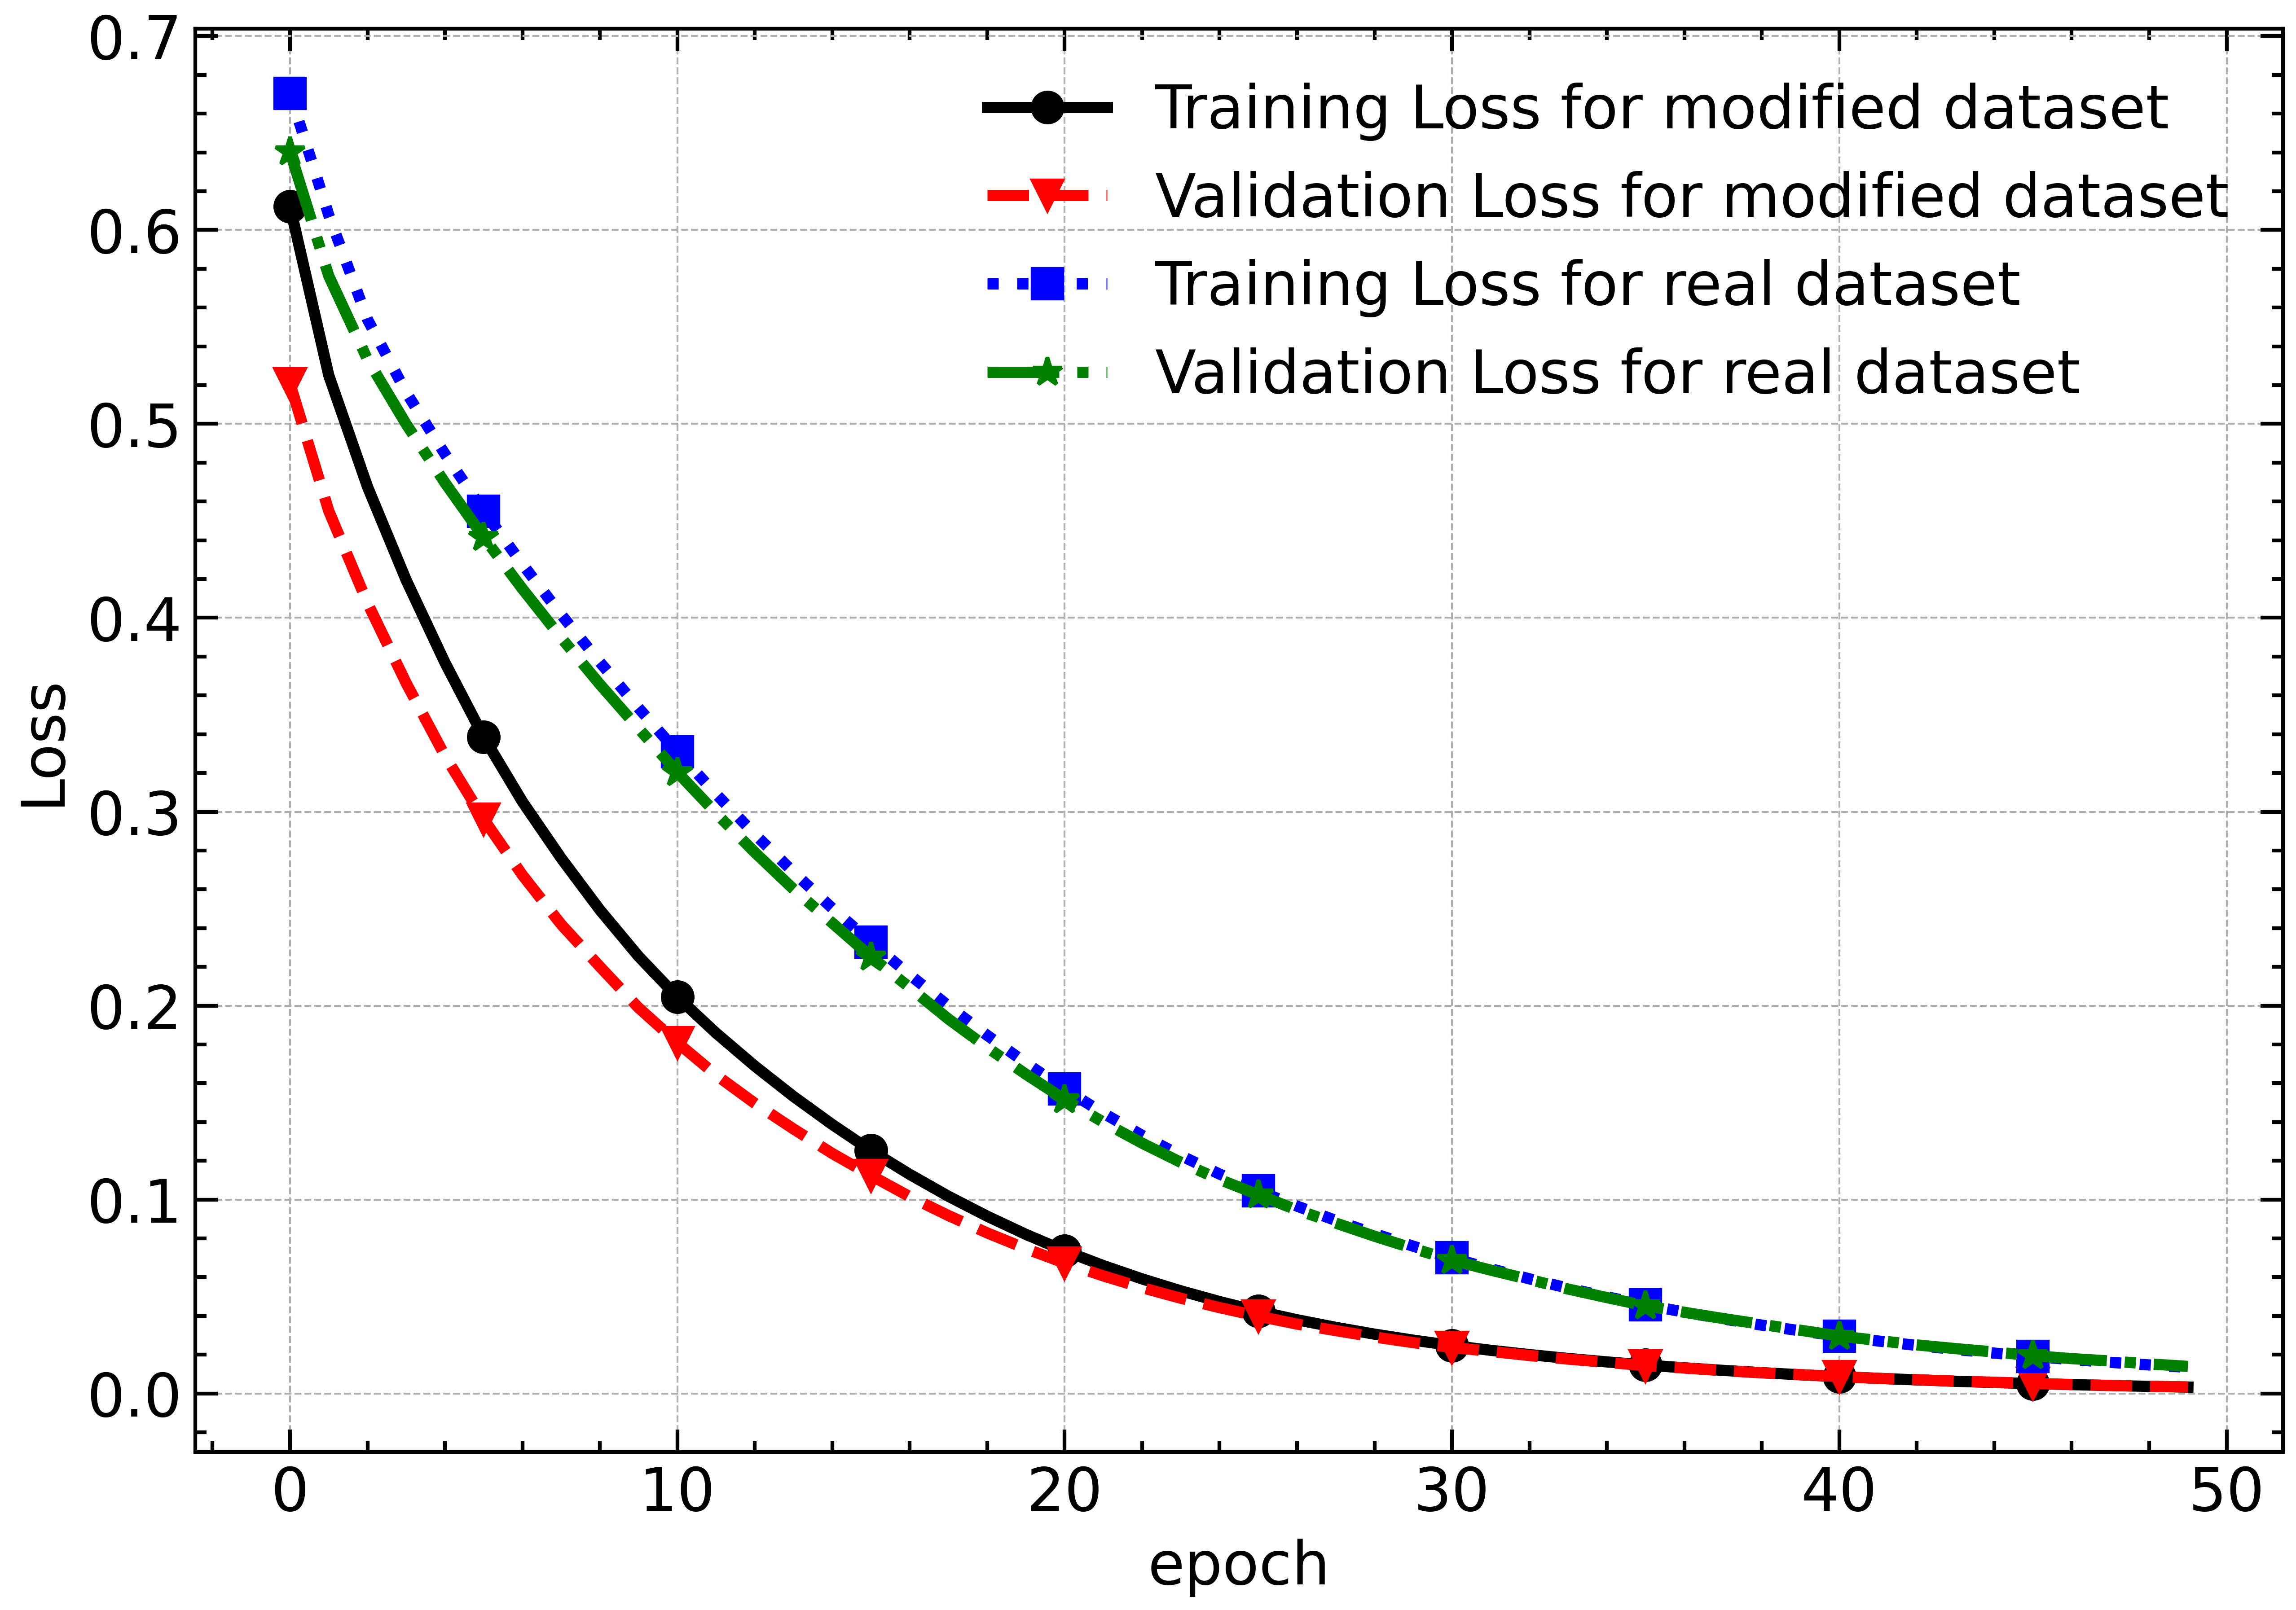


Time Taken by Real Training Data for achieving 100% or highest accuracy : 45.52 seconds. 

Time Taken by Modified Training Data for achieving 100% or highest accuracy : 26.62 seconds. 

Time difference : 18.90 seconds. 

Percentage Time difference : 41.52 %. 


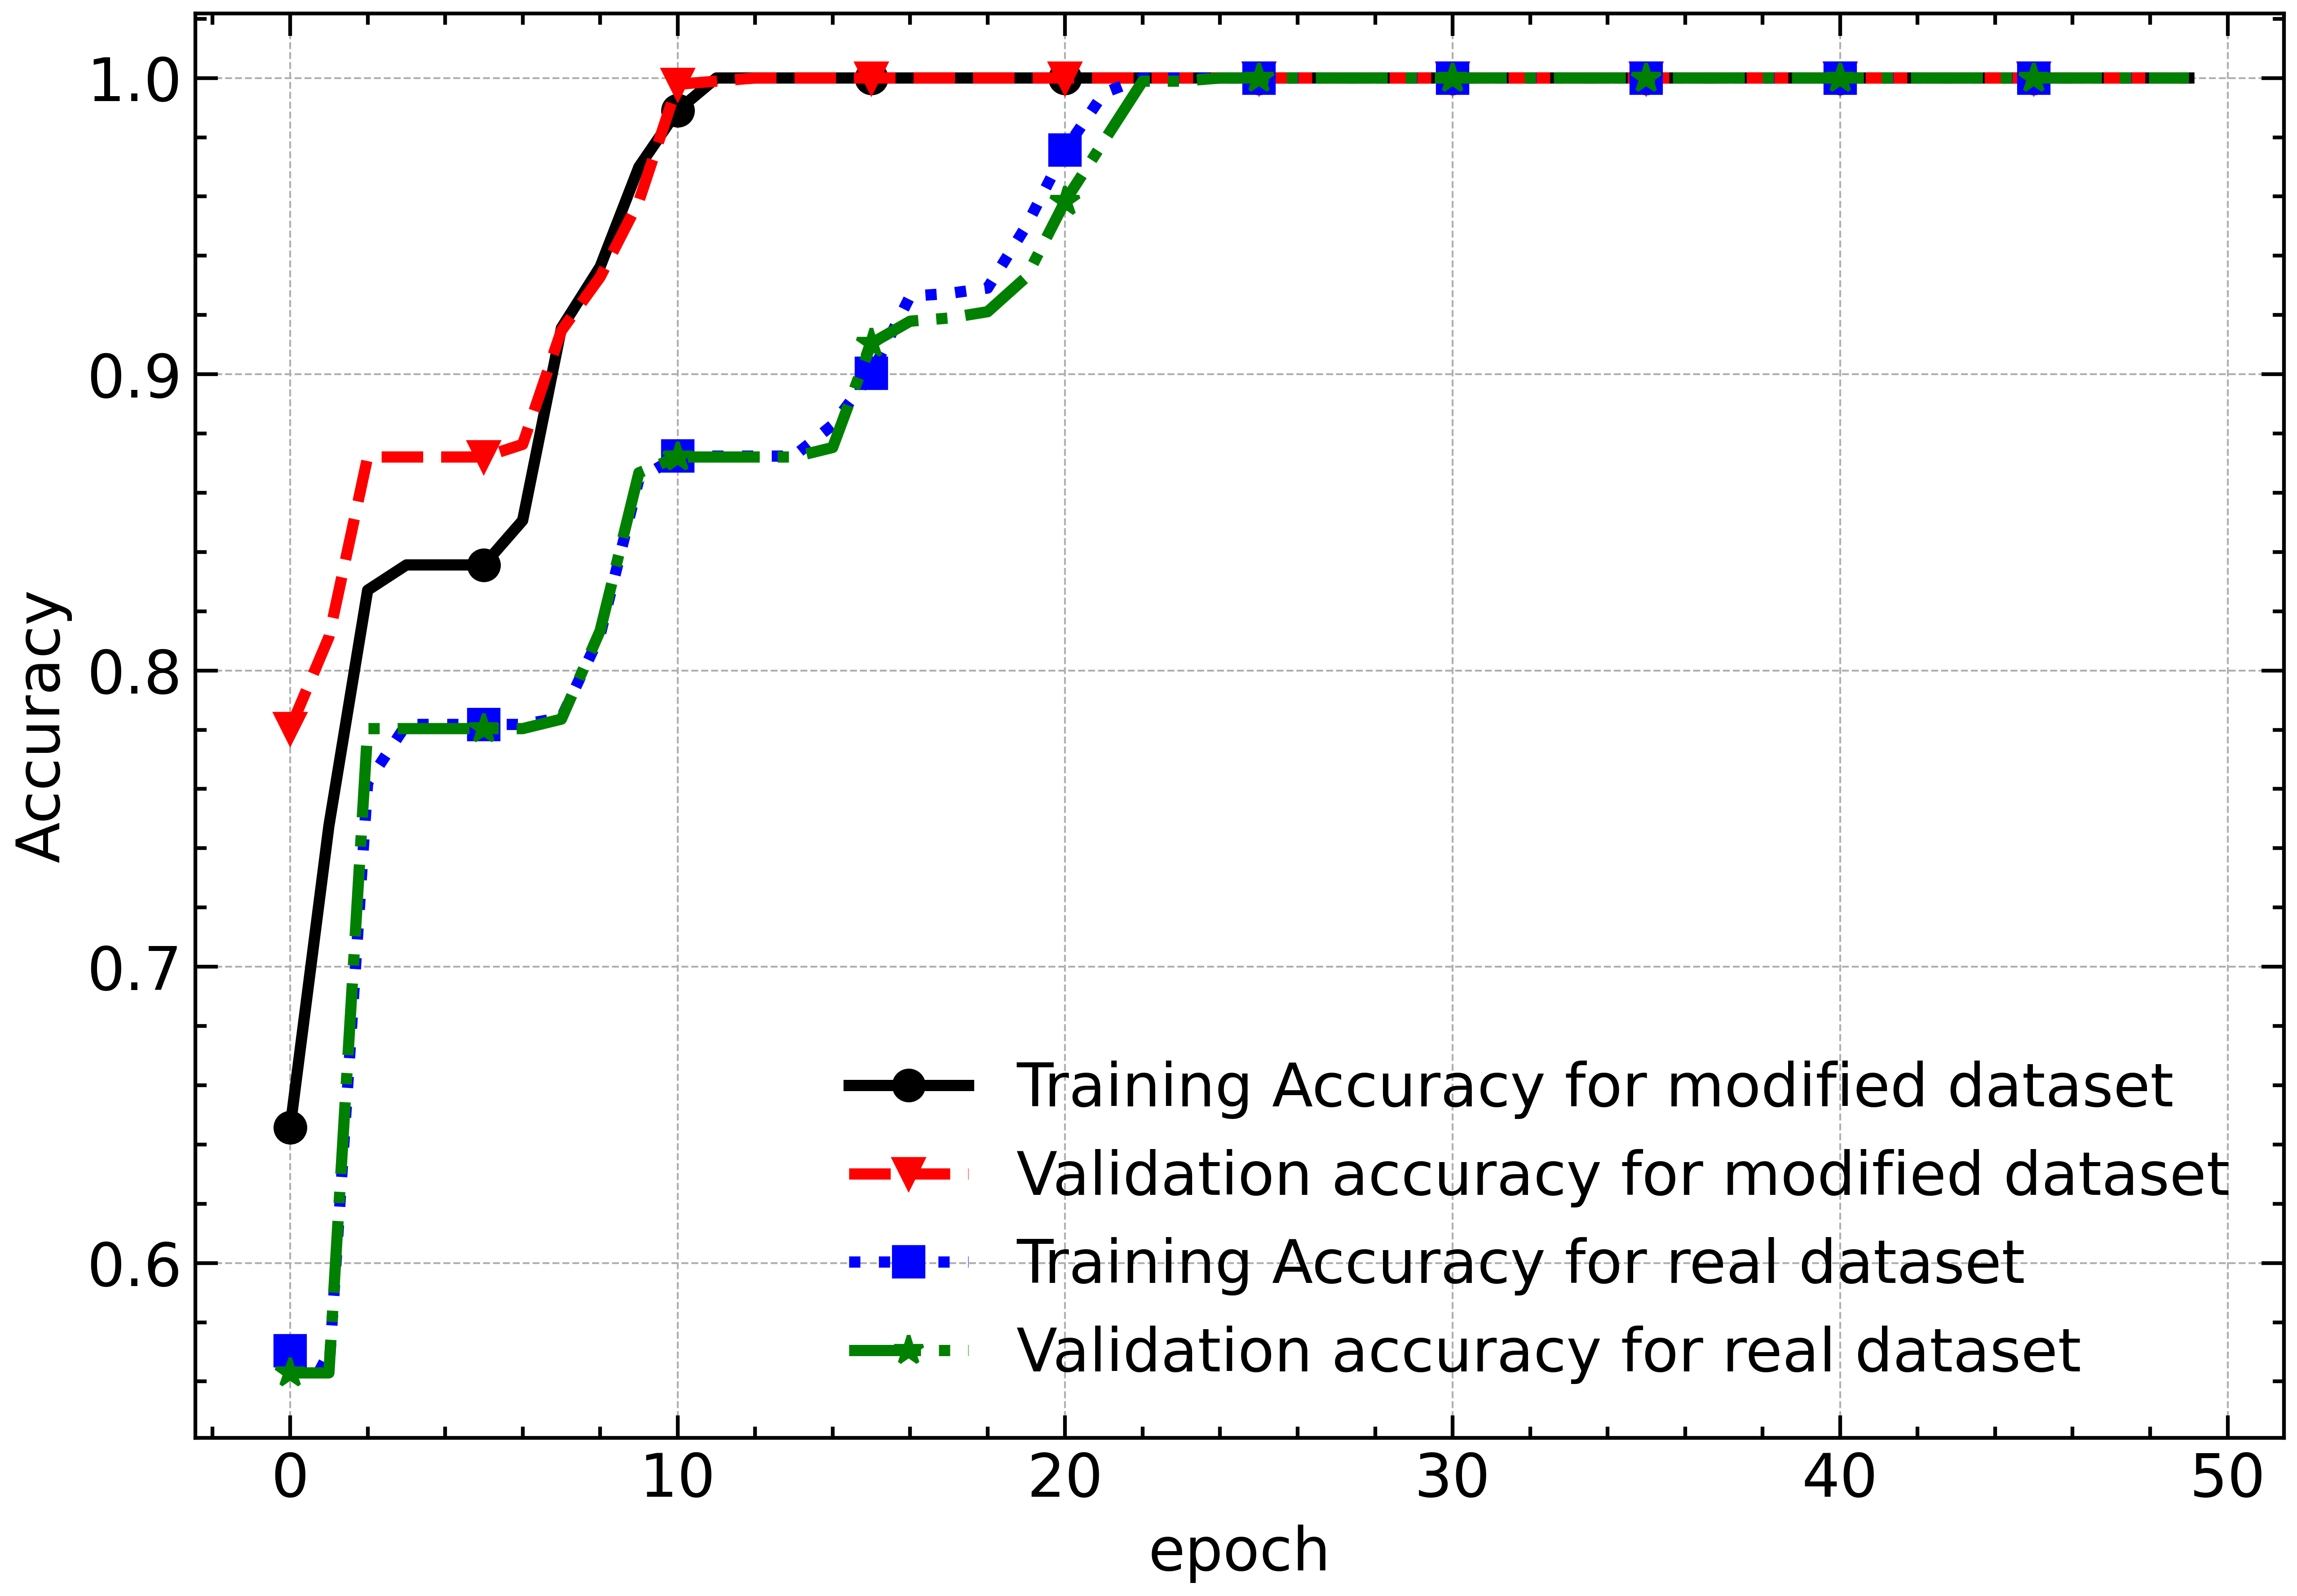

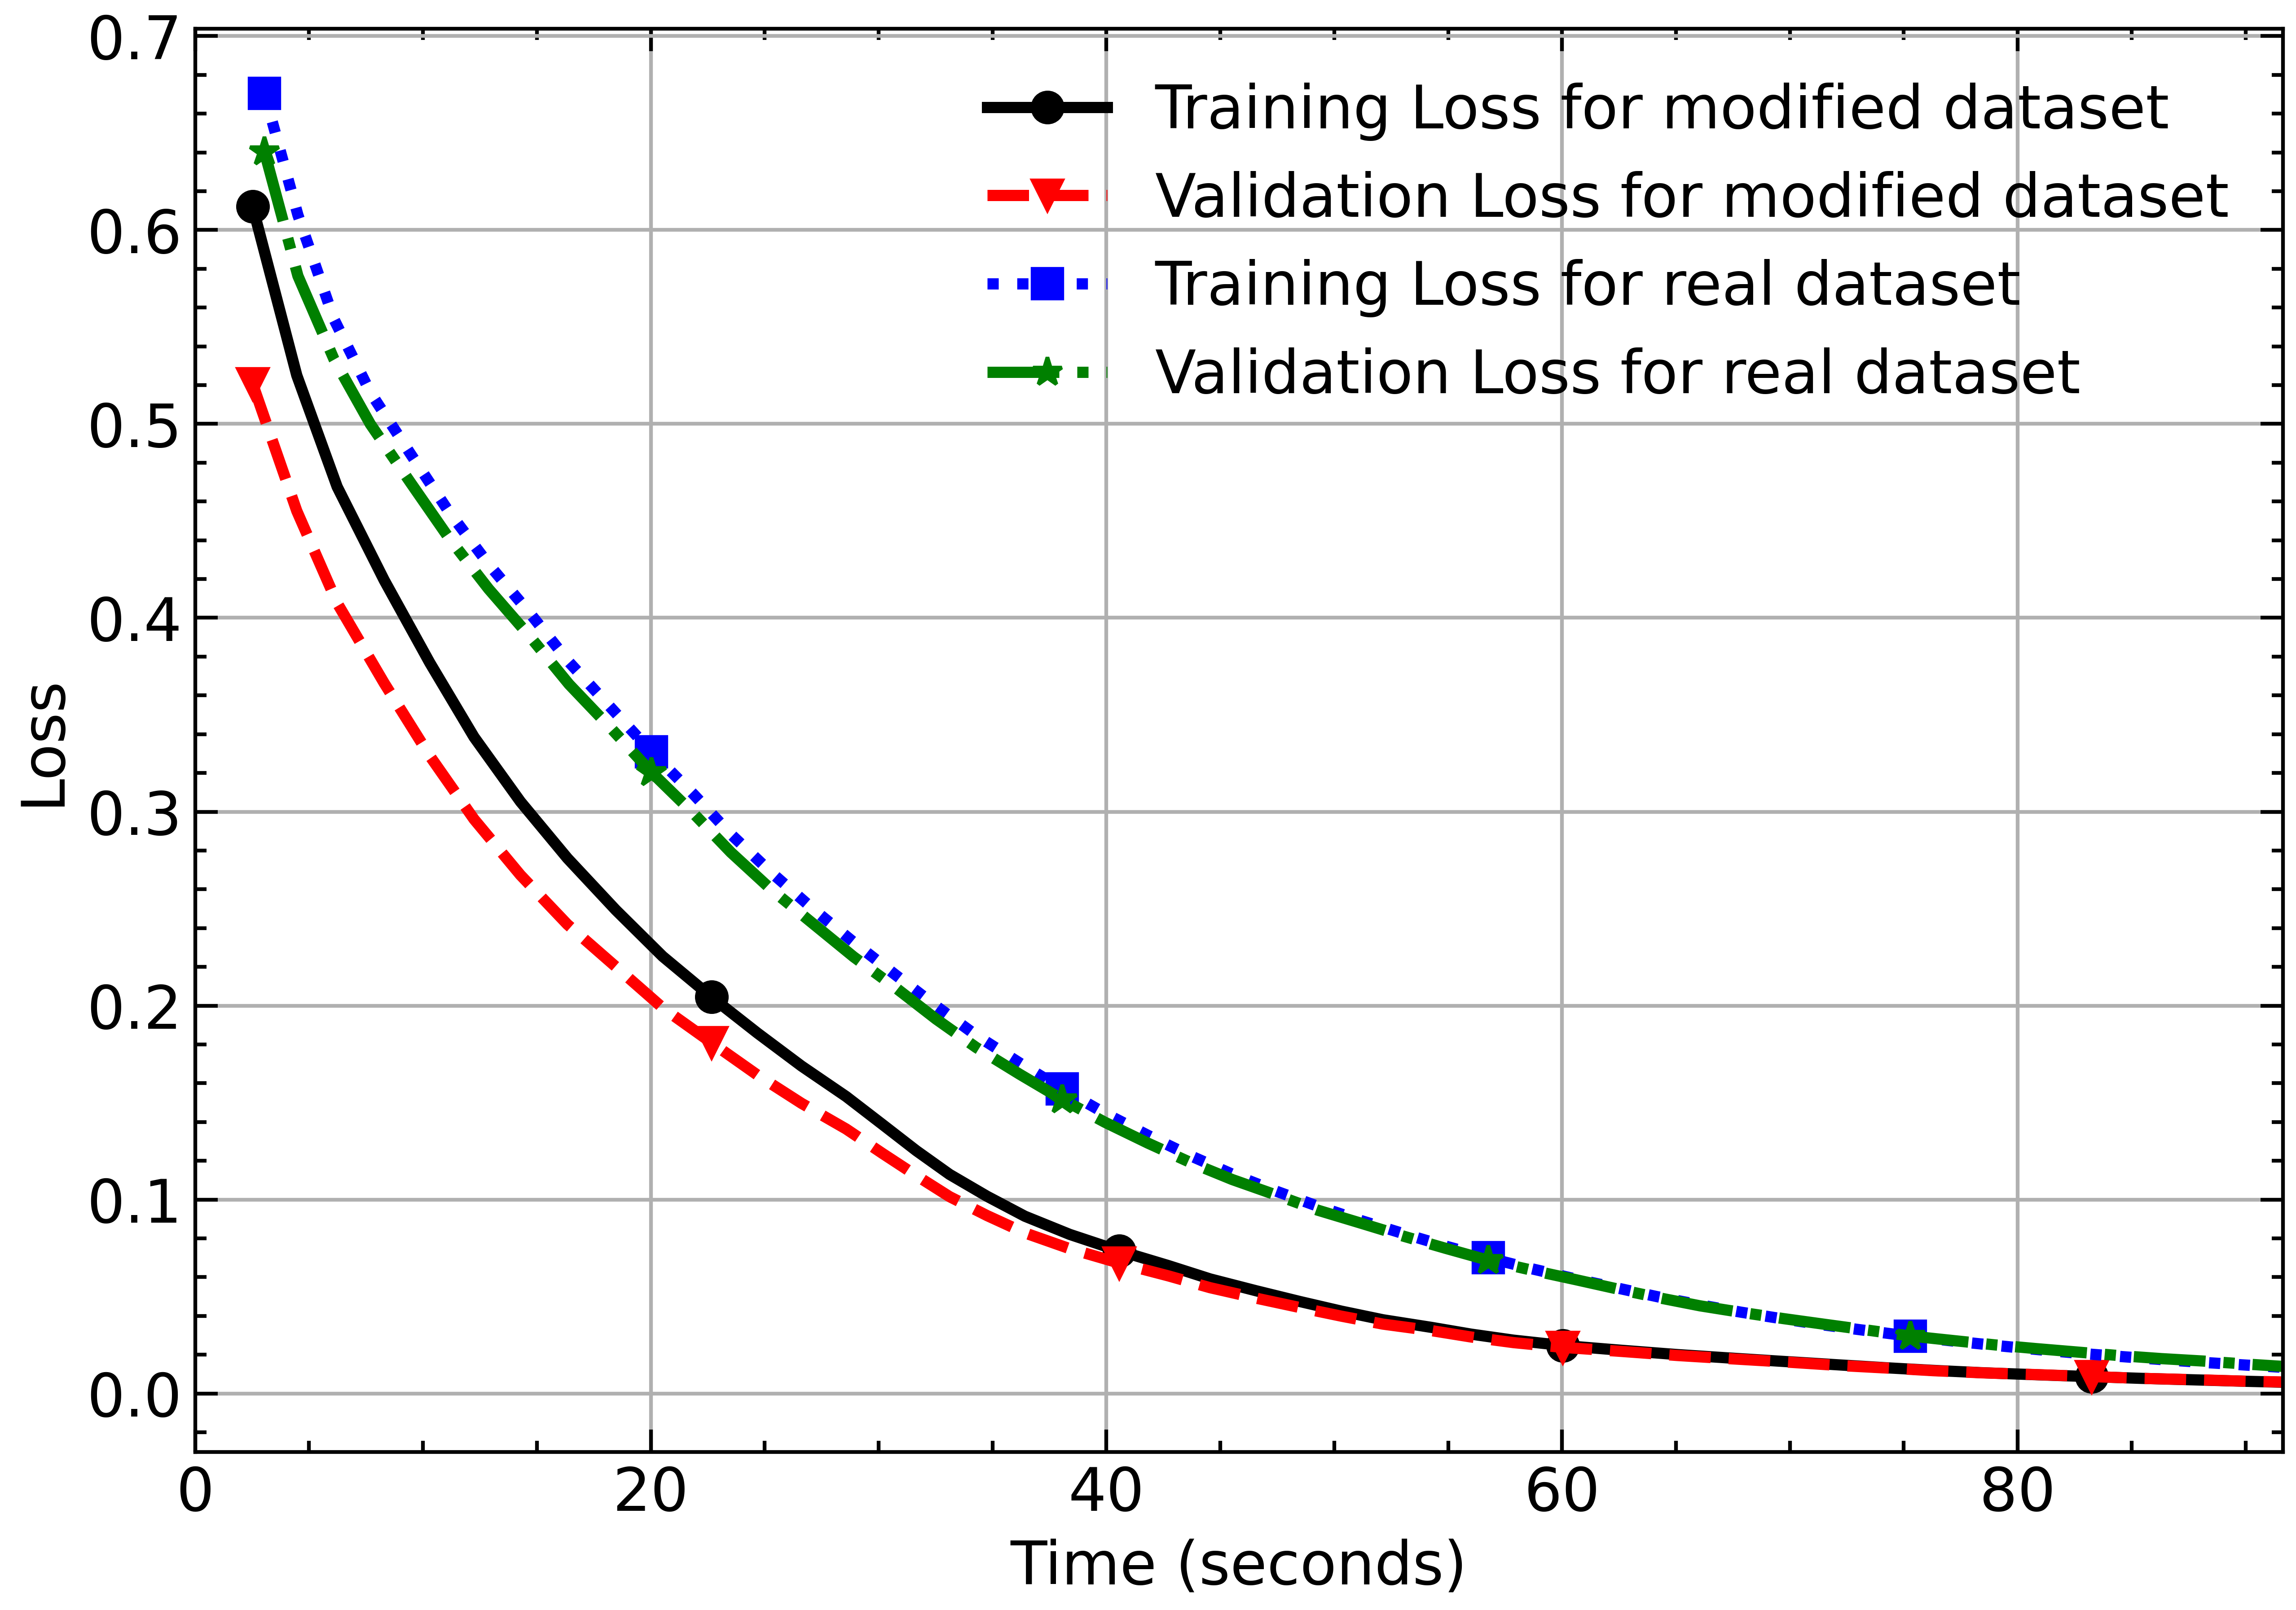

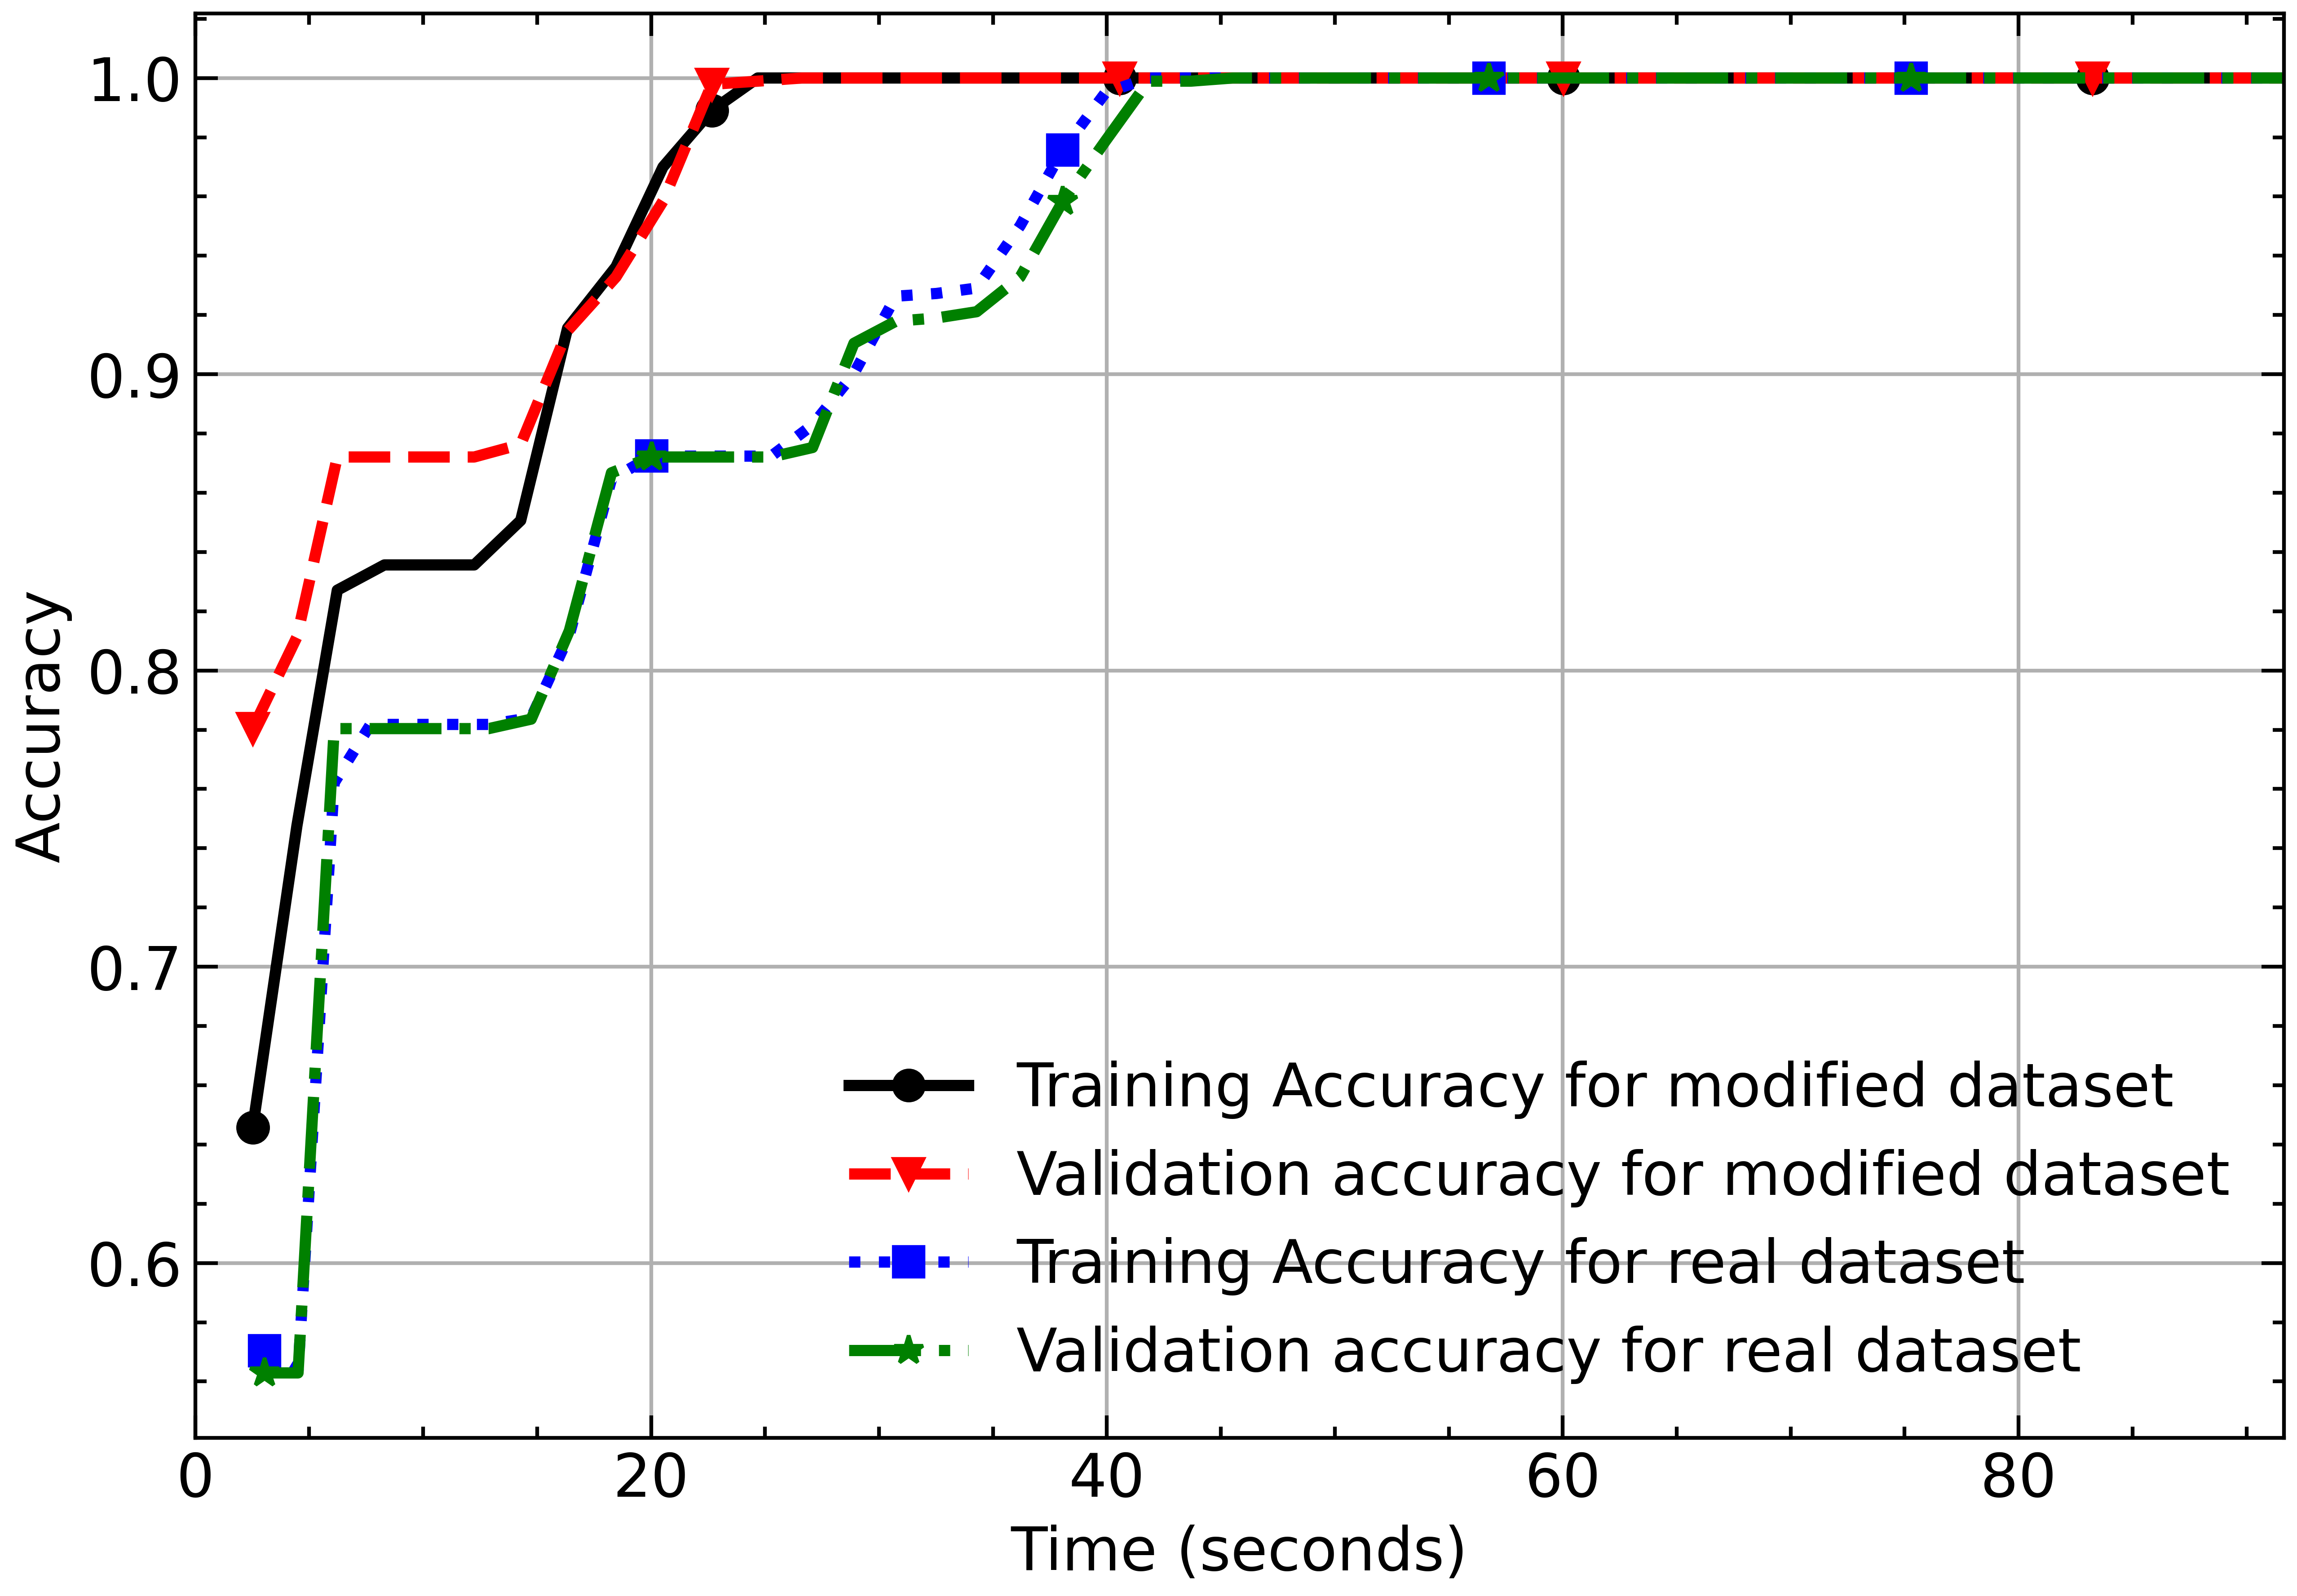

In [44]:
plot_acc_loss_curves(history1, history2,  time1, time2)